article-to-pr-mapper:
Has around 900,000 entries. Includes URL (should also be in jsonl), Title, Target URL (map to press release), date first seen, company name, and news url domain. A very large portion of the entries are missing titles. Appears to be at least 1/4th of the entries. Then at a certian point there are no titles at all. But the other columns are filled out. Additionally, some of the titles are not very informative. For example, there are hundreds of entries with the title "Search - Business Insider". The main issue with this dataset appears to be the titles.

Full-source-scored-data.jsonl:
This file includes strings titled article_url, Each article also has "links" which is a loarge list of dictionaries with href, text, and char_start_idx. There is target_timestamp (float) which appears to be in milliseconds. There are also "attributions" which are lists of strings containing different references from the article. One clear issue with this dataset seems to be with the attributions field. There are many duplicates of sources just formatted in different ways. Additionally, there is also a decent amount of large sentence fragments which can make things more complicated. Another issue lies with the links field. There are many links for each article and some of them include insignificant and irrelevant links such as "share this page".

all-coref-resolved.tar:
This saves to my computer as a folder because it is in the Hugging Face Datasets format but it is a dataset with hundreds of thousands of articles with the following fields: article_url, target_timestamp_key (internal key), target_timestamp (when the article was captured), sort_criteria, wayback_url (URL of archived snapshot), wayback_timestamp (when archive snapshot was taken), 
method (of scraping), links(list of links in article), article_text (full article text), word_lists (words per sentence), sent_lists (sentences from the article), best_class (classification labels), coref_resolved_sents (the sentences but all the pronouns have been replaced with their associated nouns). The most clear issues to me are that a lot of the articles have no article_text and coref_resolved_sents. Another issue is that article_url is missing or incorrectly formatted for some which is problematic because this is what must be consistent with the other datasets in order to merge them. 

In [69]:
!pip install polars
import polars as pl
from typing import Callable
from datasets import load_from_disk
from datasets import Dataset
from collections import defaultdict

python(9525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/huggingface_hub-0.29.2-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [70]:
jsonl_path = "full-source-scored-data.jsonl"
csv_path = "article-to-pr-mapper.csv"
resolved_folder = "/Users/arsheyagourav/Desktop/VIP/A4/all-coref-resolved"

In [71]:
# Reusable function to process large files in batches using Polars LazyFrame
def process_batches_lazy(path, file_type, batch_size, process_fn):
    if file_type == "jsonl":
        full_df = pl.read_ndjson(path)
    elif file_type == "csv":
        full_df = pl.read_csv(path)
    else:
        raise ValueError("Unsupported file type. Use 'jsonl' or 'csv'.")

    total_rows = full_df.height
    for offset in range(0, total_rows, batch_size):
        df = full_df.slice(offset, batch_size)
        if df.is_empty():
            break
        lazy_df = df.lazy()
        process_fn(lazy_df)


def process_batches_from_hf_dataset(hf_dataset, batch_size, process_fn):
    total_rows = len(hf_dataset)
    for i in range(0, total_rows, batch_size):
        batch = hf_dataset.select(range(i, min(i + batch_size, total_rows)))
        df = pl.DataFrame({k: batch[k] for k in batch.column_names})
        lazy_df = df.lazy()
        process_fn(lazy_df)

In [72]:
# Function to check null and empty values in a lazy DataFrame
total_null_counts = {}
total_empty_counts = {}

def check_nulls_and_empties_lazy(lazy_df, selected_cols=None):
    schema = lazy_df.collect_schema()
    if selected_cols:
        schema = {k: v for k, v in schema.items() if k in selected_cols}

    #print(f"🧪 Checking columns: {list(schema.keys())}")

    # Null counts
    null_exprs = [pl.col(col).is_null().sum().alias(col) for col in schema]
    null_counts_df = lazy_df.select(null_exprs).collect()
    null_counts = null_counts_df.to_dict(as_series=False)

    # Empty string counts (only for Utf8 columns)
    string_cols = [col for col, dtype in schema.items() if dtype == pl.Utf8]
    if string_cols:
        empty_exprs = [
            pl.col(col).cast(str).str.strip_chars().eq("").sum().alias(col)
            for col in string_cols
        ]
        empty_counts_df = lazy_df.select(empty_exprs).collect()
        empty_counts = empty_counts_df.to_dict(as_series=False)
    else:
        empty_counts = {}

    return null_counts, empty_counts
    

In [73]:
# Wrapper to accumulate results across batches

def run_lazy_checks(dataset_name, process_fn, batch_fn, *args, selected_cols=None, **kwargs):
    print(f"\n--- Checking {dataset_name} dataset ---")
    total_null_counts = {}
    total_empty_counts = {}

    def accumulate_counts(lazy_df):
        nonlocal total_null_counts, total_empty_counts
        nulls, empties = check_nulls_and_empties_lazy(lazy_df, selected_cols)
        #print(f"✅ Nulls: {nulls}\n✅ Empties: {empties}")
        for col, count in nulls.items():
            total_null_counts[col] = total_null_counts.get(col, 0) + count[0]
        for col, count in empties.items():
            total_empty_counts[col] = total_empty_counts.get(col, 0) + count[0]

    batch_fn(*args, process_fn=accumulate_counts, **kwargs)
    print("\n Total null values ({}):".format(dataset_name), total_null_counts)
    print(" Total empty string values ({}):".format(dataset_name), total_empty_counts)

In [74]:
# Run for each dataset
# Run for each dataset
#run_lazy_checks("JSONL", check_nulls_and_empties_lazy, process_batches_lazy, jsonl_path, "jsonl", 100_000)
#run_lazy_checks("CSV", check_nulls_and_empties_lazy, process_batches_lazy, csv_path, "csv", 100_000)



In [75]:
#4.2 and 4.3
def run_source_counts(
    dataset_label: str,
    file_path: str,
    file_type: str,
    batch_size: int,
    source_column: str
):
    print(f"\n📊 Counting '{source_column}' sources in {dataset_label} dataset")

    # Dictionary to accumulate counts across batches
    source_counter = defaultdict(int)

    def accumulate_counts(lazy_df):
        try:
            batch_counts = (
                lazy_df
                .group_by(source_column)
                .agg(pl.len().alias("count"))
                .collect()
            )

            for row in batch_counts.iter_rows(named=True):
                source = row[source_column]
                count = row["count"]
                source_counter[source] += count

        except Exception as e:
            print(f"⚠️ Skipping batch due to error: {e}")

    # Use the existing batch processor
    process_batches_lazy(
        path=file_path,
        file_type=file_type,
        batch_size=batch_size,
        process_fn=accumulate_counts
    )

    # Display results as Polars DataFrame
    result_df = (
        pl.DataFrame({
            source_column: list(source_counter.keys()),
            "total_count": list(source_counter.values())
        })
        .sort("total_count", descending=True)
    )

    print(f"\n📋 Total source counts in {dataset_label} dataset:")
    display(result_df)

In [76]:
run_source_counts(
    dataset_label="News Articles",
    file_path=csv_path,
    file_type="csv",
    batch_size=100_000,
    source_column="news_url_domain"
)



📊 Counting 'news_url_domain' sources in News Articles dataset

📋 Total source counts in News Articles dataset:


news_url_domain,total_count
str,i64
"""businessinsider""",80606
"""cbsnews""",64546
"""cnbc""",52562
"""pbs""",44027
"""fortune""",43387
…,…
"""postsouth""",1
"""chicagomaroon""",1
"""oneidadispatch""",1


In [77]:
run_source_counts(
    dataset_label="Press Releases",
    file_path=csv_path,
    file_type="csv",
    batch_size=100_000,
    source_column="company_name"
)



📊 Counting 'company_name' sources in Press Releases dataset

📋 Total source counts in Press Releases dataset:


company_name,total_count
str,i64
"""corporate""",39823
"""newscorp""",39391
"""ice""",39382
"""go_factset""",38991
"""usa_visa""",33739
…,…
"""ir_archgroup""",1
"""investors_essexapartmenthomes""",1
"""investors_irco""",1


In [78]:
# News Articles
news_df = pl.read_ndjson(jsonl_path).with_columns([
    pl.col("article_url").str.strip_chars_chars().alias("article_url_clean")
])

# Article-to-PR mapping
mapper_df = pl.read_csv(csv_path).with_columns([
    pl.col("URL").str.strip_chars_chars().alias("article_url_clean"),
    pl.col("Target URL").str.strip_chars_chars().alias("press_release_url_clean")
])

# Coref-resolved dataset from HuggingFace
resolved_df = pl.DataFrame({k: resolved_data[k] for k in resolved_data.column_names}).with_columns([
    pl.col("article_url").str.strip_chars_chars().alias("article_url_clean")
])

AttributeError: 'ExprStringNameSpace' object has no attribute 'strip_chars_chars'

In [ ]:
print("🔗 Merging news and mapper data...")
merged_1 = news_df.join(mapper_df, on="article_url_clean", how="inner")
print(f"✅ News + Mapper merged: {merged_1.shape[0]} rows")

print("🔗 Merging with coref-resolved...")
merged_final = merged_1.join(resolved_df, on="article_url_clean", how="inner")
print(f"✅ Fully merged dataset: {merged_final.shape[0]} rows")

In [ ]:
# How many news articles didn't join with the mapper
news_only = news_df.join(mapper_df, on="article_url_clean", how="anti")
print(f"⚠️ Articles not in mapper: {news_only.shape[0]}")

# How many mappings didn't match coref
mapper_only = mapper_df.join(resolved_df, on="article_url_clean", how="anti")
print(f"⚠️ Mapper records not in coref-resolved: {mapper_only.shape[0]}")

# How many coref entries had no match in mapper/news
coref_only = resolved_df.join(mapper_df, on="article_url_clean", how="anti")
print(f"⚠️ Coref-resolved records not in mapper: {coref_only.shape[0]}")

In [10]:
from graphviz import Digraph

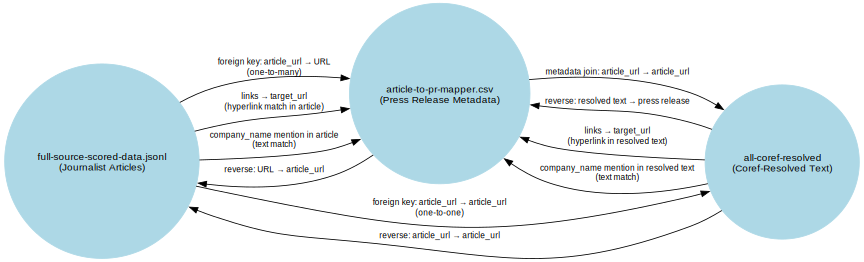

In [11]:
# Create the graph
g = Digraph("DatasetRelationships", format="svg")
g.attr(rankdir="LR", size="12,8")

# Dataset nodes
g.attr("node", shape="circle", style="filled", color="lightblue", fontname="Helvetica", fontsize="12")
g.node("A", "full-source-scored-data.jsonl\n(Journalist Articles)")
g.node("B", "article-to-pr-mapper.csv\n(Press Release Metadata)")
g.node("C", "all-coref-resolved\n(Coref-Resolved Text)")

# Edge formatting
g.attr("edge", fontname="Helvetica", fontsize="10")

# -- Explicit joins --
g.edge("A", "B", label="foreign key: article_url → URL\n(one-to-many)")
g.edge("B", "A", label="reverse: URL → article_url")

g.edge("A", "C", label="foreign key: article_url → article_url\n(one-to-one)")
g.edge("C", "A", label="reverse: article_url → article_url")

g.edge("B", "C", label="metadata join: article_url → article_url")
g.edge("C", "B", label="reverse: resolved text → press release")

# -- Implicit relationships --
g.edge("A", "B", label="links → target_url\n(hyperlink match in article)")
g.edge("C", "B", label="links → target_url\n(hyperlink in resolved text)")

g.edge("A", "B", label="company_name mention in article\n(text match)")
g.edge("C", "B", label="company_name mention in resolved text\n(text match)")

# Display in notebook
g

caption here